In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
from interface_pde import BasePDE

from utils_uq_vi import VIBPINN
from utils_pde_damposcillation import DampedOscillator1D
from utils_pde_poisson import Poisson1D
from utils_result_viz import * # plot_truth_and_samples_1D, plot_training_history

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon GPU (M1/M2/M3)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")   # Fallback to CPU

device = torch.device("cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Example: 1D Poisson equation, u''(x) = f(x) on [0,1], with u(0)=0, u(1)=0.
# Define f(x) (source term). For example, f(x) = -π^2 * sin(πx) has true solution u(x)=sin(πx) on [0,1] with zero boundary.
omega_true = 2*np.pi    # undamped frequency
zeta_true  = 0.1       # damping ratio
A   = 0.5          # new amplitude
phi = 1.2          # new phase in radians
omega_d = omega_true*np.sqrt(1-zeta_true**2)
t0 = torch.zeros((1, 1), device=device, dtype=torch.float32)  # no grads needed
x0_val = A * math.cos(phi)                     # scalar Python float
v0_val = -A * zeta_true * omega_true * math.cos(phi)  \
        - A * omega_d      * math.sin(phi)
x0 = torch.tensor([[x0_val ]], device=device, dtype=torch.float32)
v0 = torch.tensor([[v0_val]], device=device, dtype=torch.float32)

In [3]:
# Analytical solution function
def x_true(t):
    # Underdamped solution: A*exp(-zeta*omega*t) * cos(omega_d*t + phi)
    return A * np.exp(-zeta_true*omega_true*t) * np.cos(omega_d*t + phi)


# Define source function: f(x) = -π² sin(πx)
def f_func(x):
    return 0

In [4]:
data_noise = 0.05

pde = DampedOscillator1D(
    zeta_true,
    omega_true, 
    f_func, 
    (x0, v0),
    (0, 5),
    x_true)

# Generate training and testing data of the poisson function
(X_train, Y_train) = pde.data_generation(300, data_noise)
(X_test, Y_test) = pde.data_generation(100, data_noise)

# Collocation points in (0,5)
x_colloc_num = 300
x_collocation = torch.linspace(0.0, 5.0, steps=x_colloc_num).view(-1, 1)
x_collocation = x_collocation[(x_collocation > 0) & (x_collocation < 5)].view(-1, 1)

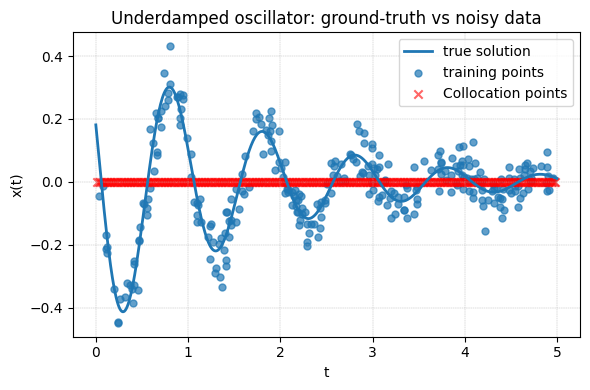

In [5]:
fig, ax = plot_truth_and_samples_1D(
    x0     = 0,
    x1     = 5,
    X_train   = X_train,
    Y_train   = Y_train,
    true_solution=x_true,
    x_colloc = x_collocation,
    title     = "Underdamped oscillator: ground-truth vs noisy data"
)

## Training 

In [6]:
# from draft import VIBPINN
from utils_uq_dropout import DropoutPINN
do_poisson_model = DropoutPINN(pde, 1, [16, 32, 64, 128, 128, 64, 32, 16], 1)
loss_dict = do_poisson_model.fit_do_pinn(x_colloc_num, X_train=X_train, Y_train=Y_train, epochs=40000, lr=3e-3,
                               λ_pde=10.0,λ_ic=5.0,λ_bc=1.0,)

Using device: cpu
ep     1 | L=6.02e+02 | data=5.82e-02 | pde=5.55e+01  ic=9.16e+00  bc=0.00e+00 | lr=3.00e-03
ep   500 | L=4.78e+01 | data=1.96e-02 | pde=3.93e-01  ic=8.76e+00  bc=0.00e+00 | lr=3.00e-03
ep  1000 | L=3.95e+01 | data=1.88e-02 | pde=7.00e-01  ic=6.48e+00  bc=0.00e+00 | lr=3.00e-03
ep  1500 | L=2.63e+01 | data=1.80e-02 | pde=8.24e-01  ic=3.59e+00  bc=0.00e+00 | lr=3.00e-03
ep  2000 | L=3.27e+01 | data=1.74e-02 | pde=3.79e-01  ic=5.77e+00  bc=0.00e+00 | lr=3.00e-03
ep  2500 | L=2.53e+01 | data=1.64e-02 | pde=6.47e-01  ic=3.75e+00  bc=0.00e+00 | lr=3.00e-03
ep  3000 | L=2.21e+01 | data=1.46e-02 | pde=6.92e-01  ic=3.02e+00  bc=0.00e+00 | lr=3.00e-03
ep  3500 | L=2.55e+01 | data=1.61e-02 | pde=4.50e-01  ic=4.18e+00  bc=0.00e+00 | lr=3.00e-03
ep  4000 | L=2.88e+01 | data=1.47e-02 | pde=1.15e+00  ic=3.44e+00  bc=0.00e+00 | lr=3.00e-03
ep  4500 | L=2.19e+01 | data=1.37e-02 | pde=1.40e+00  ic=1.57e+00  bc=0.00e+00 | lr=3.00e-03
ep  5000 | L=1.87e+01 | data=1.42e-02 | pde=7.19e-01

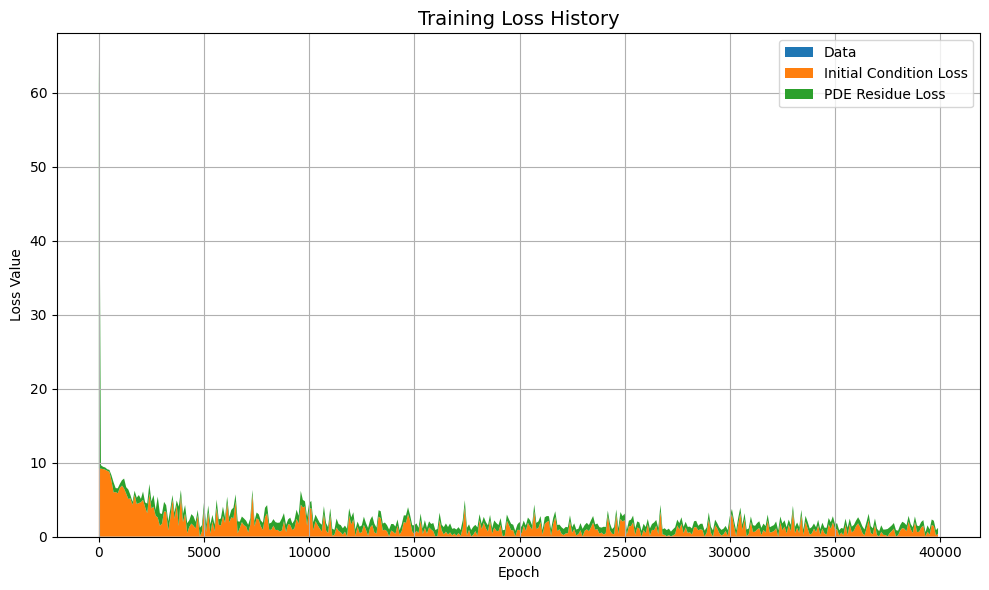

In [7]:
plot_training_history(loss_dict, plot_after=0, step=100)

## Prediction

In [8]:
x_grid = torch.linspace(0, 5, 100).view(-1, 1)
pred_set = do_poisson_model.predict(x_grid, n_samples=1000, alpha=0.05)

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


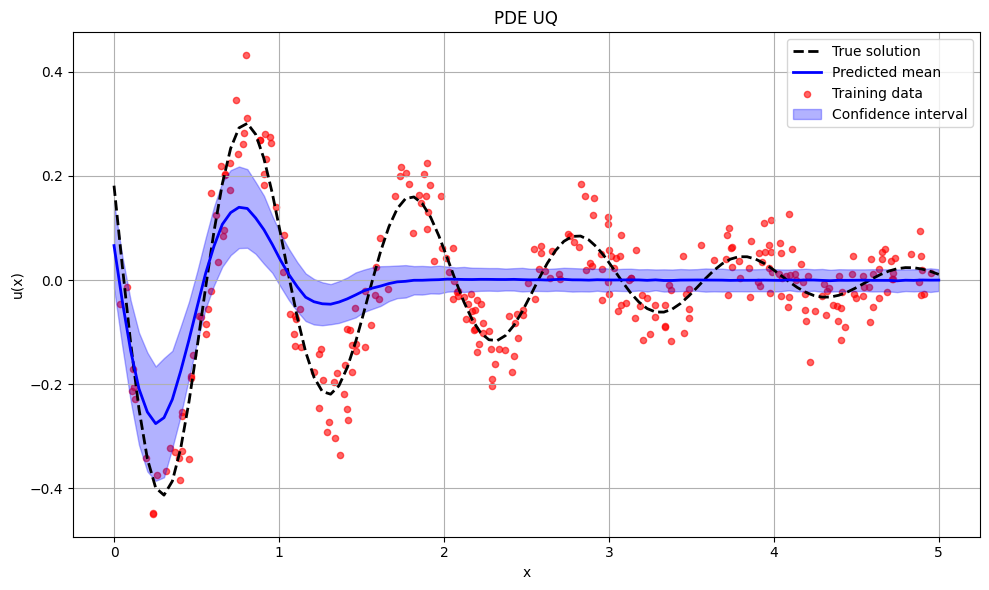

In [9]:
plot_predictions_1D(x_grid, pred_set, x_true, X=X_train, Y=Y_train)

## Sharpness & Coverage

In [10]:
from utils_result_metrics import do_test_uncertainties
def generating_alphas(a_num):
    alphas = torch.linspace(0.0, 1.0, 10).view(-1, 1)
    return alphas[1:a_num-1]

alphas = generating_alphas(10)

rslt = do_test_uncertainties(do_poisson_model, alphas, X_test, Y_test, n_samples=100)

Using device: cpu


  0%|          | 0/8 [00:00<?, ?it/s]/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 8/8 [00:00<00:00, 12.44it/s]


## Uncertainty Plot


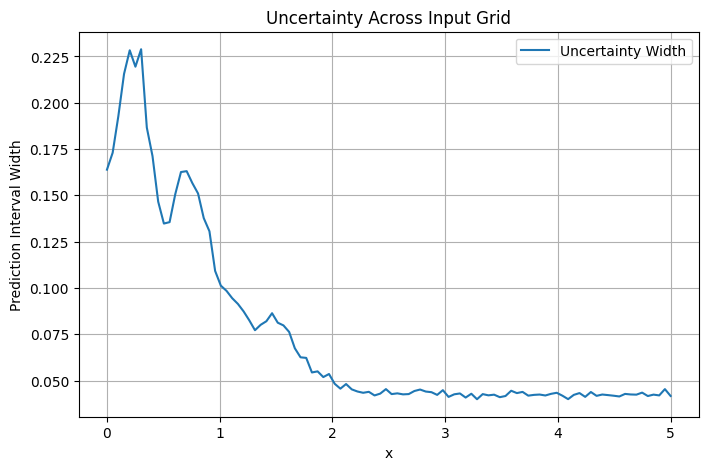

In [11]:
from utils_result_metrics import plot_uncertainty
plot_uncertainty(pred_set, x_grid)